# Prepare John Snow data

In [1]:
%pylab inline

import matplotlib.pyplot as plt
import pysal as ps
import geopandas as gpd
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Datasets:

* Ordnance Survey Open Map shapefile for the city of Westminster, provided by the [CDRC](http://data.cdrc.ac.uk) ([link](https://data.cdrc.ac.uk/dataset/cdrc-2015-os-geodata-pack-westminster-e09000033)).
* Cholera Deaths.

In [2]:
os_blg = '../data/Building.shp'
os_str = '../data/os_streets.shp'
deaths_link = '../data/Cholera_Deaths.shp'

## OS network

* **Network**

The shapefile `os_streets.shp` comes originally from Ordnance Survey Open Data, downloaded through QGIS and cleaned so there are no islands.

In [3]:
ntw = ps.Network('../data/os_streets.shp')
ntw.snapobservations(deaths_link, \
                     'deaths', attribute=True)

Because this splits some of the lines, we need to create a new shapefile with one row per segment so it can be aligned later on with the weights matrix. We keep the new segment ids into a list named `segids`:

In [4]:
fo = ps.open('../data/streets_js.shp', 'w')
lens = []
segids = []
for seg in ntw.edges:
    orig, dest = seg
    segids.append(seg)
    orig = ps.cg.Point(ntw.node_coords[orig])
    dest = ps.cg.Point(ntw.node_coords[dest])
    line = ps.cg.Chain([orig, dest])
    lens.append(line.len)
    fo.write(line)
fo.close()
!cp ../data/streets_osm_clean_prjd.prj ../data/streets_js.prj

cp: cannot stat ‘../data/streets_osm_clean_prjd.prj’: No such file or directory


To link the number of deaths to each street segment, we need to access the point pattern created as part of the `ntw` object:

In [5]:
pp = ntw.pointpatterns['deaths']
d2seg = {}
for death in pp.dist_to_node:
    nodes = pp.dist_to_node[death].keys()
    d2seg[death] = (min(nodes), max(nodes))
d2seg = pd.Series(d2seg)
d2seg.head()

0    (12, 84)
1    (12, 84)
2    (12, 84)
3    (12, 84)
4    (12, 84)
dtype: object

If we read the table for the cholera deaths as a `GeoDataFrame`, we can append the segment ID:

In [6]:
deaths = gpd.read_file(deaths_link)
deaths['segID'] = d2seg
deaths.head()

Count  Id                                     geometry     segID
0      3   0  POINT (529308.7414200425 181031.3515464273)  (12, 84)
1      2   0   POINT (529312.163571333 181025.1724011325)  (12, 84)
2      1   0  POINT (529314.3824294576 181020.2936884186)  (12, 84)
3      1   0  POINT (529317.3796448297 181014.2587706869)  (12, 84)
4      4   0  POINT (529320.6754489439 181007.8716281414)  (12, 84)

At this point, we can create a table for death counts per segment, which will be our resulting dataset. Not that this operation removes the `geometry` column, but that is ok.

In [7]:
deaths_by_seg = deaths.groupby('segID').sum()
deaths_by_seg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, (0, 2) to (119, 120)
Data columns (total 2 columns):
Count    64 non-null int64
Id       64 non-null int64
dtypes: int64(2)
memory usage: 1.5+ KB


To align `deaths_by_seg` with the segment shapefile we have created above, we have to reindex it with `segids`:

In [8]:
deaths_by_seg = deaths_by_seg.reindex(segids)\
                             .fillna(0)\
                             .drop(['Id'], axis=1)
deaths_by_seg['seg_len'] = pd.Series(lens, index=segids)
deaths_by_seg['segIdStr'] = deaths_by_seg.index
deaths_by_seg['segIdStr'] = deaths_by_seg['segIdStr'].apply(lambda x: 's%i-%i'%(x[0], x[1]))
deaths_by_seg = deaths_by_seg.reset_index()\
                             .drop('segID', axis=1)\
                             .rename(columns={'Count': 'Deaths'})
deaths_by_seg['Deaths_dens'] = deaths_by_seg['Deaths'] * 100. / deaths_by_seg['seg_len']
deaths_by_seg.head()

Deaths     seg_len segIdStr  Deaths_dens
0       0    6.403124     s0-1     0.000000
1       1   92.773279     s0-2     1.077897
2       0   38.418745     s0-3     0.000000
3       0   39.623226    s1-25     0.000000
4      26  143.808901    s1-27    18.079549

This can be written into a `dbf` to match the shapefile created above:

In [9]:
from pysal.contrib.pdutilities.dbf_utilities import df2dbf
df2dbf(deaths_by_seg, '../data/streets_js.dbf')

'../data/streets_js.dbf'

Next is to create spatial weights:

In [10]:
w = ntw.contiguityweights(graph=False)
w.remap_ids(['s%i-%i'%(i[0], i[1]) for i in w.id_order])
w.id_order[-5:]

Island id:  [(60, 61)]


['s115-117', 's116-117', 's116-118', 's118-119', 's119-120']

Which we can write as well:

In [11]:
fo = ps.open('../data/streets_js_contiguity.gal', 'w')
fo.write(w)
fo.close()

## Aggregate by Ordnance Survey polygons

### Read Data

* OS building data

In [12]:
blg = gpd.read_file(os_blg).set_index('id')
blg.head()

featcode  \
id                                           
0D4F7074F94727B3E050A00A568A259B     15014   
0D4F7074F1E927B3E050A00A568A259B     15014   
0D4F7074F1EA27B3E050A00A568A259B     15014   
0D4F7074F69727B3E050A00A568A259B     15014   
0D4F7074F1E527B3E050A00A568A259B     15014   

                                                                           geometry  
id                                                                                   
0D4F7074F94727B3E050A00A568A259B  POLYGON ((528798.4 180486.23, 528835.24 180439...  
0D4F7074F1E927B3E050A00A568A259B  POLYGON ((528204.75 178528.31, 528223.49 17854...  
0D4F7074F1EA27B3E050A00A568A259B  POLYGON ((528235.02 178559.59, 528293.4 178501...  
0D4F7074F69727B3E050A00A568A259B  POLYGON ((528284.6800000001 178559.29, 528275....  
0D4F7074F1E527B3E050A00A568A259B  POLYGON ((528183.22 178509.47, 528163.43999999...

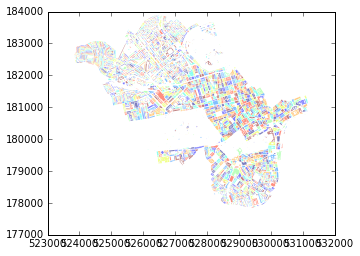

In [13]:
blg.plot(linewidth=0)

* Read in deaths

In [14]:
deaths = gpd.read_file(deaths_link)
# Project to same CRS as buildings
deaths = deaths.to_crs(blg.crs)
deaths.head()

Count  Id                                     geometry
0      3   0  POINT (529308.7414201582 181031.3515459803)
1      2   0   POINT (529312.1635714488 181025.172400685)
2      1   0  POINT (529314.3824295733 181020.2936879725)
3      1   0  POINT (529317.3796449455 181014.2587702405)
4      4   0  POINT (529320.6754490597 181007.8716276955)

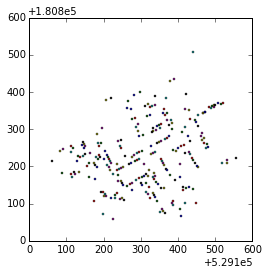

In [15]:
deaths.plot()

### Prepare Data

The original shapefile contains too many buildings that are not part of John Snow's area of study. The first step is to get rid of those polygons that are not in the bounding box of the `deaths` points. An option to do this is to create the convex hull of the points and intersect it with the building data: 

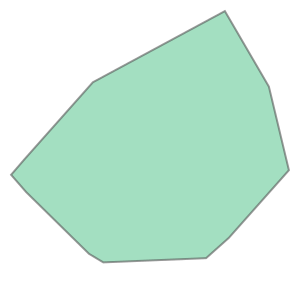

In [16]:
# Deaths' union convex hull
ch = deaths.unary_union.convex_hull
ch

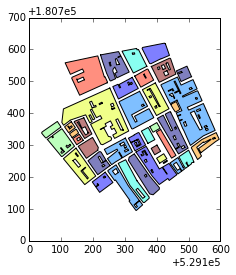

In [17]:
# Intersect OS building data w/ convex hull
blg_js = blg.intersects(ch)
ids_in = blg_js[blg_js==True].index
blg_js = blg.reindex(ids_in)
blg_js.plot()

In [18]:
blg_js.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 39 entries, 0D4F7075050927B3E050A00A568A259B to 0D4F707508FB27B3E050A00A568A259B
Data columns (total 2 columns):
featcode    39 non-null float64
geometry    39 non-null object
dtypes: float64(1), object(1)
memory usage: 936.0+ bytes


Now the next step is to aggregate deaths data at the building level, rather than at the point, which is how it comes provided. Let us inspect first if every point falls into a polygon, which would make the aggregation more straightforward:

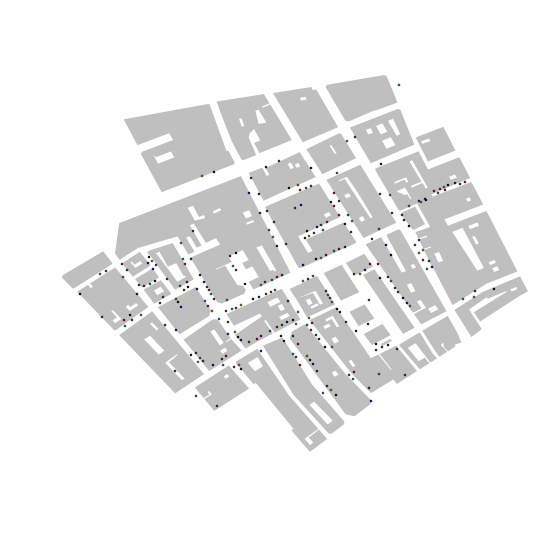

In [19]:
f, ax = plt.subplots(1, figsize=(9, 9))
for poly in blg_js.geometry:
    gpd.plotting.plot_multipolygon(ax, poly, facecolor='grey', linewidth=0)
deaths.plot(axes=ax, markersize=50)
ax.set_axis_off()
plt.show()

Unfortunately, this is not the case. Since not every point clearly falls into a given polygon, we need to come up with a rule to snap each point to one and only one polygon. We decide to join each point to the nearest polygon, as determined by that which has a point of its edge closest to the point of deaths. To implement it, we adopt a brute force approach that, because we are working with a small dataset, runs quickly and keeps the code readable and easy to understand:

In [20]:
pt2poly = {}
exts = blg_js.exterior
for pid, row in deaths.iterrows():
    pt = row['geometry']
    # Get distance to each polygon
    nrst_pt_in_poly = exts.apply(lambda ext: ext.interpolate(ext.project(pt)))
    dist2polys = nrst_pt_in_poly.distance(pt)
    min_dist = dist2polys.loc[dist2polys==dist2polys.min()]
    pt2poly[pid] = min_dist.index[0]
pt2poly = pd.DataFrame({'os_poly': pt2poly})

TypeError: Only linear types support this operation

Once we know which polygon is closest to each of the points, we can bring this information to the `deaths` table to get a count of deaths by polygon:

In [ ]:
# Sum deaths by poly ID
deaths_by_poly = deaths.join(pt2poly).groupby('os_poly').sum()[['Count']]
# Reindex to original list of polygons to bring back polys with zero counts
deaths_by_poly = deaths_by_poly.reindex(blg_js.index).fillna(0)
deaths_by_poly.head()

We can join the result to the original OS buildig subset:

In [ ]:
db = blg_js.join(deaths_by_poly).rename(columns={'Count': 'Deaths'})
blg_js['Deaths'] = deaths_by_poly['Count']
blg_js.plot(column='Deaths', colormap='Blues')

Because polygons differ in size substantially, let us also calculate the density of deaths by polygon:

In [ ]:
blg_js['Death_dens'] = blg_js['Deaths'] / blg_js.area
blg_js.plot(column='Death_dens', scheme='Quantiles', colormap='Blues', linewidth=0)

This final table can be written into a GeoJSON file:

In [ ]:
blg_js['ID'] = blg_js.index
blg_js.to_file('../data/deaths_by_poly')